In [1]:
# Install basic modules and make sure they are available with the latest pip version.
# Always updating PIP could be either good or bad, you just have to choose one base on the situation around.

# I use --quiet and --no-warn-script-location to hide the output of my directory paths
import sys
import os

!{sys.executable} -m pip install --upgrade pip matplotlib numpy tensorflow-macos tensorflow-metal scikit-learn --quiet --no-warn-script-location

In [ ]:
import os
import requests
import zipfile

# Path to current working directory
downlod_path = os.getcwd()
downlod_path = downlod_path.replace("investigation", "kaggledataset")

# Download the dataset using http request
# url = "https://www.kaggle.com/api/v1/datasets/download/mostafaabla/garbage-classification"
url = "https://www.kaggle.com/api/v1/datasets/download/sumn2u/garbage-classification-v2"
response = requests.get(url, allow_redirects=True)

# zip_path = os.path.join(downlod_path, 'garbage-classification.zip')
zip_path = os.path.join(downlod_path, 'garbage-classification-v2.zip')
with open(zip_path, 'wb') as file:
    file.write(response.content)

# Extract the zip file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(downlod_path)

print(f"Dataset downloaded and extracted to {downlod_path}")

In [2]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
import numpy as np
import os
from PIL import Image
import glob
import matplotlib.pyplot as plt
from tensorflow.keras import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping
from sklearn.utils.class_weight import compute_class_weight


In [2]:
# Define dataset path
dataset_path = os.path.join(os.getcwd().replace("investigation", "kaggledataset"), 'garbage_classification')

# Load all images and labels
image_data = []
labels = []
class_names = sorted(os.listdir(dataset_path))
# Skip the . files present
class_names = [class_name for class_name in class_names if not class_name.startswith(".")]
print(f"Classes: {class_names}")

for class_idx, class_name in enumerate(class_names):
    class_folder = os.path.join(dataset_path, class_name)
    if os.path.isdir(class_folder):
        for img_file in glob.glob(os.path.join(class_folder, "*.jpg")):
            try:
                # Open the image, resize, and normalize
                img = Image.open(img_file).convert("RGB").resize((256, 256))
                image_data.append(np.array(img) / 255.0)  # Normalize to 0-1 range
                labels.append(class_idx)
            except Exception as e:
                print(f"Error loading image {img_file}: {e}")

# Convert to NumPy arrays
image_data = np.array(image_data, dtype="float32")
labels = np.array(labels)

# One-hot encode the labels
labels_one_hot = to_categorical(labels, num_classes=len(class_names))

# Split data into 80/20 train/validation
train_data, test_data, train_labels, test_labels = train_test_split(
    image_data, labels_one_hot, test_size=0.2, random_state=42, stratify=labels
)

print(f"Train data shape: {train_data.shape}")
print(f"Train labels shape: {train_labels.shape}")
print(f"Validation data shape: {test_data.shape}")
print(f"Validation labels shape: {test_labels.shape}")

Classes: ['battery', 'biological', 'brown-glass', 'cardboard', 'clothes', 'green-glass', 'metal', 'paper', 'plastic', 'shoes', 'trash', 'white-glass']
Train data shape: (12412, 256, 256, 3)
Train labels shape: (12412, 12)
Validation data shape: (3103, 256, 256, 3)
Validation labels shape: (3103, 12)


In [ ]:
num_classes = len(class_names)  # Number of classes

# Our input feature map is 256x256x3: 256x150 for the image pixels, and 3 for
# the three color channels: R, G, and B
# Input layer
# img_input = layers.Input(shape=(256, 256, 3))
# Input layer with a static name
img_input = layers.Input(shape=(256, 256, 3), name="eco_sort_static_input_layer")

# First convolution extracts 32 filters that are 3x3
x = layers.Conv2D(
    32, 3, 
    activation=None, 
    kernel_regularizer=tf.keras.regularizers.l2(0.02),
    kernel_initializer='he_normal'
)(img_input)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.MaxPooling2D(2)(x)

# Second convolution extracts 64 filters that are 3x3
x = layers.Conv2D(
    64, 3, 
    activation=None, 
    kernel_regularizer=tf.keras.regularizers.l2(0.02),
    kernel_initializer='he_normal'
)(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.MaxPooling2D(2)(x)

# Third convolution extracts 128 filters that are 3x3
x = layers.Conv2D(
    128, 3, 
    activation=None, 
    kernel_regularizer=tf.keras.regularizers.l2(0.02),
    kernel_initializer='he_normal'
)(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.MaxPooling2D(2)(x)

# Flatten and Dense layers
x = layers.Flatten()(x)
x = layers.Dense(
    512, 
    activation=None, 
    kernel_regularizer=tf.keras.regularizers.l2(0.02),
    kernel_initializer='he_normal'
)(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.Dropout(0.8)(x)

# Output layer
output = layers.Dense(
    num_classes, 
    activation='softmax', 
    kernel_initializer='he_normal',
    name="eco_sort_static_output_layer"
)(x)

# Create model:
# input = input feature map
# output = input feature map + stacked convolution/maxpooling layers + fully 
# connected layer + sigmoid output layer
model = Model(img_input, output)
     

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ eco_sort_static_input_layer     │ (None, 256, 256, 3)    │             0 │
│ (InputLayer)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 254, 254, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_4 (ReLU)                  │ (None, 254, 254, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 125, 125, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_5 (ReLU)                  │ (None, 125, 125, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 60, 60, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_6 (ReLU)                  │ (None, 60, 60, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 115200)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │    58,982,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_7 (ReLU)                  │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ eco_sort_static_output_layer    │ (None, 12)             │         6,156 │
│ (Dense)                         │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 59,085,260 (225.39 MB)

 Trainable params: 59,083,788 (225.39 MB)

 Non-trainable params: 1,472 (5.75 KB)

In [5]:
# Define optimizer
optimizer = RMSprop(learning_rate=0.0001)

model.compile(
  loss='categorical_crossentropy',
  optimizer=optimizer,
  metrics=['acc']
)

In [6]:
class_weights = compute_class_weight('balanced', classes=np.unique(labels), y=labels)
class_weights_dict = dict(enumerate(class_weights))

early_stopping = EarlyStopping(monitor='val_acc', patience=20, verbose=1, restore_best_weights=True)

def smooth_lr(epoch):
    base_lr = 0.0001
    decay = 0.9  # Slight decay every epoch
    return base_lr * (decay ** epoch)
    
lr_scheduler = LearningRateScheduler(smooth_lr)

# Cyclical Learning Rate
def clr(epoch):
    base_lr = 0.0001
    max_lr = 0.001
    step_size = 10
    cycle = np.floor(1 + epoch / (2 * step_size))
    x = np.abs(epoch / step_size - 2 * cycle + 1)
    lr = base_lr + (max_lr - base_lr) * max(0, (1 - x))
    return lr

clr_callback = LearningRateScheduler(clr)

# Class weights
class_weights = compute_class_weight('balanced', classes=np.unique(labels), y=labels)
class_weights_dict = dict(enumerate(class_weights))

validation_data = tf.data.Dataset.from_tensor_slices((test_data, test_labels)).shuffle(1000).batch(32)

In [7]:
result = model.fit(
  train_data,
  train_labels,
  epochs=50,
  batch_size=32,
  validation_data=validation_data,
  verbose=1,
  class_weight=class_weights_dict,
  callbacks=[early_stopping, lr_scheduler]
)

Epoch 1/50


2024-12-15 12:52:57.046282: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


388/388 ━━━━━━━━━━━━━━━━━━━━ 51s 118ms/step - acc: 0.3353 - loss: 25.8523 - val_acc: 0.6300 - val_loss: 11.6569 - learning_rate: 1.0000e-04
Epoch 2/50
388/388 ━━━━━━━━━━━━━━━━━━━━ 45s 115ms/step - acc: 0.5091 - loss: 11.0131 - val_acc: 0.6352 - val_loss: 8.4987 - learning_rate: 9.0000e-05
Epoch 3/50
388/388 ━━━━━━━━━━━━━━━━━━━━ 45s 116ms/step - acc: 0.5625 - loss: 8.5129 - val_acc: 0.6368 - val_loss: 7.4934 - learning_rate: 8.1000e-05
Epoch 4/50
388/388 ━━━━━━━━━━━━━━━━━━━━ 45s 116ms/step - acc: 0.6100 - loss: 7.5162 - val_acc: 0.6507 - val_loss: 6.9596 - learning_rate: 7.2900e-05
Epoch 5/50
388/388 ━━━━━━━━━━━━━━━━━━━━ 45s 117ms/step - acc: 0.6530 - loss: 6.9555 - val_acc: 0.6955 - val_loss: 6.4406 - learning_rate: 6.5610e-05
Epoch 6/50
388/388 ━━━━━━━━━━━━━━━━━━━━ 45s 115ms/step - acc: 0.6644 - loss: 6.5589 - val_acc: 0.7161 - val_loss: 6.1427 - learning_rate: 5.9049e-05
Epoch 7/50
388/388 ━━━━━━━━━━━━━━━━━━━━ 45s 115ms/step - acc: 0.6993 - loss: 6.1703 - val_acc: 0.7290 - val_loss: 

In [8]:
model.save("saved_models/garbage_classification_model_sunday_cnn_h5.h5")
model.save("saved_models/garbage_classification_model_sunday_cnn_tf_keras.keras")
model.export("saved_models/garbage_classification_model_sunday_cnn_tf_keras")

INFO:tensorflow:Assets written to: saved_models/garbage_classification_model_sunday_cnn_tf_keras/assets


INFO:tensorflow:Assets written to: saved_models/garbage_classification_model_sunday_cnn_tf_keras/assets


Saved artifact at 'saved_models/garbage_classification_model_sunday_cnn_tf_keras'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name='eco_sort_static_input_layer')
Output Type:
  TensorSpec(shape=(None, 12), dtype=tf.float32, name=None)
Captures:
  14220892768: TensorSpec(shape=(), dtype=tf.resource, name=None)
  14220893472: TensorSpec(shape=(), dtype=tf.resource, name=None)
  14220893120: TensorSpec(shape=(), dtype=tf.resource, name=None)
  14220892592: TensorSpec(shape=(), dtype=tf.resource, name=None)
  14220899808: TensorSpec(shape=(), dtype=tf.resource, name=None)
  14220890128: TensorSpec(shape=(), dtype=tf.resource, name=None)
  14220893296: TensorSpec(shape=(), dtype=tf.resource, name=None)
  14220901744: TensorSpec(shape=(), dtype=tf.resource, name=None)
  14222050224: TensorSpec(shape=(), dtype=tf.resource, name=None)
  14222050400: TensorSpec(shape=(), dtype=tf.resource, name=N

97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step
Overall Test Accuracy: 0.79


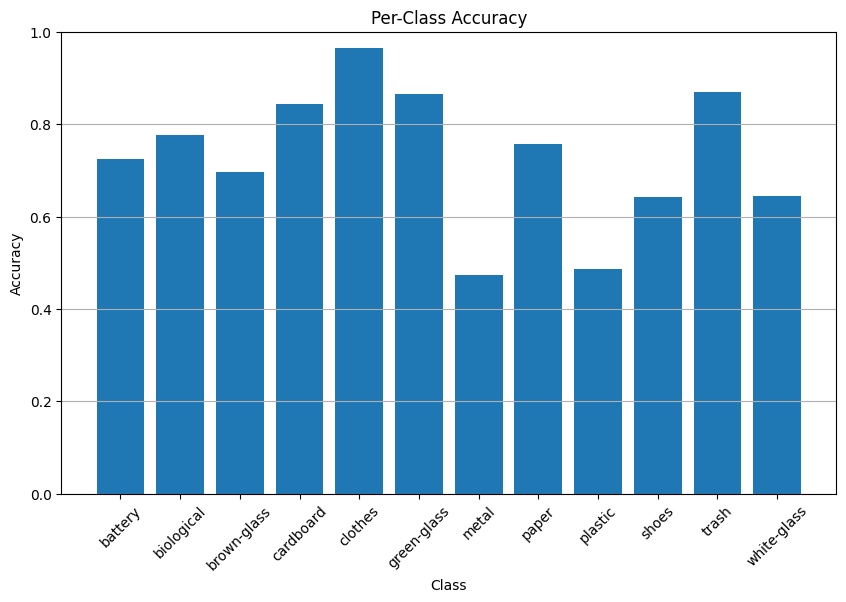

In [9]:
##############################################
# Get predictions for the test data
predictions = model.predict(test_data)

# Convert predictions and true labels from one-hot to class indices
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(test_labels, axis=1)

# Calculate overall accuracy
overall_accuracy = np.sum(predicted_classes == true_classes) / len(true_classes)
print(f"Overall Test Accuracy: {overall_accuracy:.2f}")

# Calculate per-class accuracy
num_classes = len(class_names)
class_accuracies = []
for class_index in range(num_classes):
    indices = np.where(true_classes == class_index)[0]
    class_correct = np.sum(predicted_classes[indices] == true_classes[indices])
    class_accuracy = class_correct / len(indices) if len(indices) > 0 else 0
    class_accuracies.append(class_accuracy)

# Plot per-class accuracy
plt.figure(figsize=(10, 6))
plt.bar(class_names, class_accuracies)
plt.title("Per-Class Accuracy")
plt.xlabel("Class")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.grid(axis="y")
plt.show()


In [12]:
from sklearn.metrics import classification_report, accuracy_score
import numpy as np

# Get predictions for the test data
predictions = model.predict(test_data)

# Convert predictions and true labels from one-hot encoding to class indices
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(test_labels, axis=1)

# Compute overall accuracy
accuracy = accuracy_score(true_classes, predicted_classes)
print(f"Overall Accuracy: {accuracy:.2f}")

# Compute classification report (includes Precision, Recall, F1-Score)
report = classification_report(true_classes, predicted_classes, target_names=class_names)
print("Classification Report:")
print(report)


97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step
Overall Accuracy: 0.79
Classification Report:
              precision    recall  f1-score   support

     battery       0.72      0.72      0.72       189
  biological       0.73      0.78      0.75       197
 brown-glass       0.79      0.70      0.74       122
   cardboard       0.82      0.84      0.83       178
     clothes       0.88      0.96      0.92      1065
 green-glass       0.85      0.87      0.86       126
       metal       0.57      0.47      0.52       154
       paper       0.83      0.76      0.79       210
     plastic       0.60      0.49      0.54       173
       shoes       0.79      0.64      0.71       395
       trash       0.66      0.87      0.75       139
 white-glass       0.61      0.65      0.63       155

    accuracy                           0.79      3103
   macro avg       0.74      0.73      0.73      3103
weighted avg       0.79      0.79      0.79      3103



In [10]:
print("Input Tensor:")
for input_tensor in model.inputs:
    print(f"Name: {input_tensor.name}, Shape: {input_tensor.shape}, Dtype: {input_tensor.dtype}")

print("\nOutput Tensor:")
for output_tensor in model.outputs:
    print(f"Name: {output_tensor.name}, Shape: {output_tensor.shape}, Dtype: {output_tensor.dtype}")

Input Tensor:
Name: eco_sort_static_input_layer, Shape: (None, 256, 256, 3), Dtype: float32

Output Tensor:
Name: keras_tensor_35, Shape: (None, 12), Dtype: float32


In [11]:
# Load the Keras model
saved_model = tf.saved_model.load('saved_models/garbage_classification_model_sunday_cnn_tf_keras')

# Check input tensor details
for key, tensor in saved_model.signatures['serving_default'].structured_input_signature[1].items():
    print(f"Input Name: {tensor.name}, Shape: {tensor.shape}, Dtype: {tensor.dtype}")

# Check output tensor details
for key, tensor in saved_model.signatures['serving_default'].structured_outputs.items():
    print(f"Output Name: {tensor.name}, Shape: {tensor.shape}, Dtype: {tensor.dtype}")

Input Name: eco_sort_static_input_layer, Shape: (None, 256, 256, 3), Dtype: <dtype: 'float32'>
Output Name: output_0, Shape: (None, 12), Dtype: <dtype: 'float32'>


In [ ]:
import tensorflow as tf

# Path to your SavedModel directory (adjust as needed)
saved_model_dir = "saved_models/1.0.0.keras"

# Create a converter object from the SavedModel
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)

converter.optimizations = [tf.lite.Optimize.DEFAULT]

# Convert the model to TFLite format
tflite_model = converter.convert()

# Save the TFLite model to a file
with open("saved_models/1.0.0.tflite", "wb") as f:
    f.write(tflite_model)

print("TFLite model conversion complete.")

2025-02-16 19:01:34.226874: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Max
2025-02-16 19:01:34.226899: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 48.00 GB
2025-02-16 19:01:34.226909: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 18.00 GB
2025-02-16 19:01:34.226930: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-02-16 19:01:34.226941: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
W0000 00:00:1739728894.616075 43853186 tf_tfl_flatbuffer_helpers.cc:390] Ignored output_format.
W0000 00:00:1739728894.616107 43853186 tf_tfl_flatbuffer_helpers.cc:393] Ignored drop

TFLite model conversion complete.


In [ ]:
import tensorflow as tf

# Disable GPU usage for conversion
tf.config.set_visible_devices([], 'GPU')

# Load your HDF5 model
model = tf.keras.models.load_model("saved_models/garbage_classification_model_79_h5.h5")

# Create a converter from the Keras model
converter = tf.lite.TFLiteConverter.from_keras_model(model)

converter.optimizations = [tf.lite.Optimize.DEFAULT]

# Convert the model
tflite_model = converter.convert()

# Write the TFLite model to a file
with open("saved_models/garbage_classification_model_79_h5.tflite", "wb") as f:
    f.write(tflite_model)

print("TFLite model conversion complete.")


INFO:tensorflow:Assets written to: /var/folders/8q/4d6ddfkn7s3blc6hyjqwr3mh0000gn/T/tmpt__75996/assets


INFO:tensorflow:Assets written to: /var/folders/8q/4d6ddfkn7s3blc6hyjqwr3mh0000gn/T/tmpt__75996/assets


: 

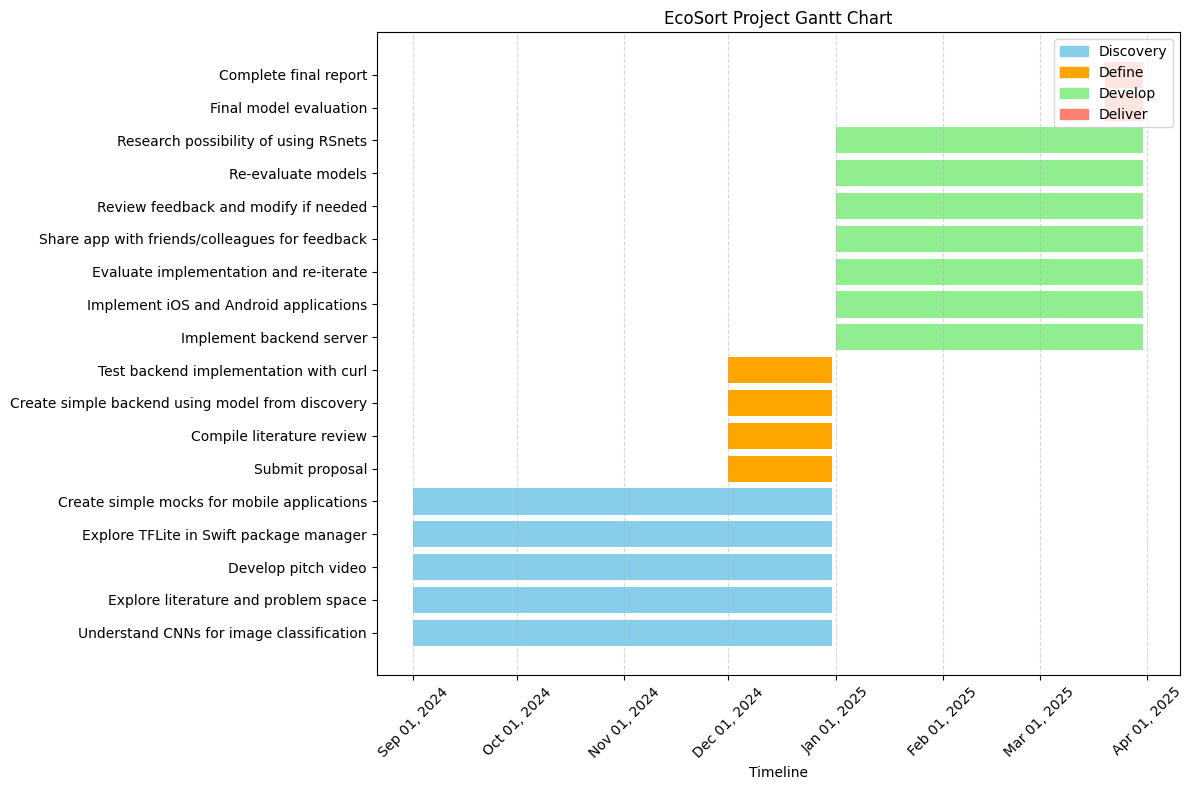

In [3]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime

# Define tasks with stage, name, start and end dates.
tasks = [
    # Discovery Stage: September 1 to December 31, 2024
    {"stage": "Discovery", "task": "Understand CNNs for image classification", 
     "start": datetime(2024, 9, 1), "end": datetime(2024, 12, 31)},
    {"stage": "Discovery", "task": "Explore literature and problem space", 
     "start": datetime(2024, 9, 1), "end": datetime(2024, 12, 31)},
    {"stage": "Discovery", "task": "Develop pitch video", 
     "start": datetime(2024, 9, 1), "end": datetime(2024, 12, 31)},
    {"stage": "Discovery", "task": "Explore TFLite in Swift package manager", 
     "start": datetime(2024, 9, 1), "end": datetime(2024, 12, 31)},
    {"stage": "Discovery", "task": "Create simple mocks for mobile applications", 
     "start": datetime(2024, 9, 1), "end": datetime(2024, 12, 31)},
    
    # Defin Stage: December 1 to December 31, 2024
    {"stage": "Define", "task": "Submit proposal", 
     "start": datetime(2024, 12, 1), "end": datetime(2024, 12, 31)},
    {"stage": "Define", "task": "Compile literature review", 
     "start": datetime(2024, 12, 1), "end": datetime(2024, 12, 31)},
    {"stage": "Define", "task": "Create simple backend using model from discovery", 
     "start": datetime(2024, 12, 1), "end": datetime(2024, 12, 31)},
    {"stage": "Define", "task": "Test backend implementation with curl", 
     "start": datetime(2024, 12, 1), "end": datetime(2024, 12, 31)},
    
    # Develop Stage: January 1 to March 31, 2025
    {"stage": "Develop", "task": "Implement backend server", 
     "start": datetime(2025, 1, 1), "end": datetime(2025, 3, 31)},
    {"stage": "Develop", "task": "Implement iOS and Android applications", 
     "start": datetime(2025, 1, 1), "end": datetime(2025, 3, 31)},
    {"stage": "Develop", "task": "Evaluate implementation and re-iterate", 
     "start": datetime(2025, 1, 1), "end": datetime(2025, 3, 31)},
    {"stage": "Develop", "task": "Share app with friends/colleagues for feedback", 
     "start": datetime(2025, 1, 1), "end": datetime(2025, 3, 31)},
    {"stage": "Develop", "task": "Review feedback and modify if needed", 
     "start": datetime(2025, 1, 1), "end": datetime(2025, 3, 31)},
    {"stage": "Develop", "task": "Re-evaluate models", 
     "start": datetime(2025, 1, 1), "end": datetime(2025, 3, 31)},
    {"stage": "Develop", "task": "Research possibility of using RSnets", 
     "start": datetime(2025, 1, 1), "end": datetime(2025, 3, 31)},
    
    # Deliver Stage: March 20 to March 31, 2025
    {"stage": "Deliver", "task": "Final model evaluation", 
     "start": datetime(2025, 3, 20), "end": datetime(2025, 3, 31)},
    {"stage": "Deliver", "task": "Complete final report", 
     "start": datetime(2025, 3, 20), "end": datetime(2025, 3, 31)},
]

# Define colors for each stage
stage_colors = {
    "Discovery": "skyblue",
    "Define": "orange",
    "Develop": "lightgreen",
    "Deliver": "salmon"
}

# Prepare figure and axis
fig, ax = plt.subplots(figsize=(12, 8))

# Create bars for each task
yticks = []
ylabels = []
height = 0.8
y_pos = 0

for task in tasks:
    start = mdates.date2num(task["start"])
    end = mdates.date2num(task["end"])
    duration = end - start
    ax.broken_barh([(start, duration)], (y_pos, height), facecolors=stage_colors[task["stage"]])
    yticks.append(y_pos + height/2)
    ylabels.append(task["task"])
    y_pos += 1

# Format the x-axis as dates
ax.xaxis_date()
date_format = mdates.DateFormatter("%b %d, %Y")
ax.xaxis.set_major_formatter(date_format)
plt.xticks(rotation=45)

# Set labels and title
ax.set_yticks(yticks)
ax.set_yticklabels(ylabels)
ax.set_xlabel("Timeline")
ax.set_title("EcoSort Project Gantt Chart")

# Add grid and legend for stages
ax.grid(True, which="both", axis="x", linestyle="--", alpha=0.5)
import matplotlib.patches as mpatches
patches = [mpatches.Patch(color=color, label=stage) for stage, color in stage_colors.items()]
plt.legend(handles=patches, loc="upper right")

plt.tight_layout()
plt.show()
